In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [148]:
plt.style.use("ggplot")

### 1. Data understanding and cleaning

In [72]:
data = pd.read_csv("train (1).csv")

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


In [74]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


#### Checking for null values

In [75]:
(data.isna().sum() * 100 / len(data)).sort_values(ascending = False)

arpu_3g_6                   74.902499
count_rech_2g_6             74.902499
night_pck_user_6            74.902499
arpu_2g_6                   74.902499
date_of_last_rech_data_6    74.902499
                              ...    
last_day_rch_amt_8           0.000000
vol_2g_mb_6                  0.000000
vol_2g_mb_7                  0.000000
vol_2g_mb_8                  0.000000
churn_probability            0.000000
Length: 172, dtype: float64

Let's drop all the features having more than 70% of null values

In [76]:
data.dropna(thresh=len(data.index) * 0.7, axis=1, inplace=True)

In [77]:
data.shape

(69999, 142)

#### Dropping redundant feature

##### Low variance feature

In [78]:
redundant_cols = []
for col in data.columns:
    counts = data[col].value_counts()
    count_max = counts.iloc[0]
    if count_max / len(data) * 100 > 95:
        redundant_cols.append(col)
redundant_cols

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'og_others_7',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'sachet_3g_6',
 'sachet_3g_7',
 'sachet_3g_8']

In [79]:
data.loc_og_t2o_mou.value_counts()

0.0    69297
Name: loc_og_t2o_mou, dtype: int64

In [80]:
data.circle_id.value_counts()

109    69999
Name: circle_id, dtype: int64

These values have very low variance and it does not contain any information, so lets drop these features

In [81]:
data.drop(redundant_cols, axis=1, inplace=True)

##### Dropping id

In [82]:
data.drop("id", axis=1, inplace=True)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 126 entries, arpu_6 to churn_probability
dtypes: float64(100), int64(23), object(3)
memory usage: 67.3+ MB


#### Data transformation

##### Lets have a look at the object types

In [84]:
data.select_dtypes('object').columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

These are all datetime fields.

In [85]:
pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.year.value_counts()

2014.0    68898
Name: date_of_last_rech_6, dtype: int64

In [86]:
pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.month.value_counts()

6.0    68898
Name: date_of_last_rech_6, dtype: int64

For each of these fields month and year are the same, so we can remove them and just keep the day

In [87]:
data['date_of_last_rech_6'] = pd.to_datetime(data['date_of_last_rech_6'], infer_datetime_format=True).dt.day

In [88]:
data['date_of_last_rech_7'] = pd.to_datetime(data['date_of_last_rech_7'], infer_datetime_format=True).dt.day

In [89]:
data['date_of_last_rech_8'] = pd.to_datetime(data['date_of_last_rech_8'], infer_datetime_format=True).dt.day

In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 126 entries, arpu_6 to churn_probability
dtypes: float64(103), int64(23)
memory usage: 67.3 MB


#### Feature engineering

##### Adding column of average revenue per user for all three months

In [91]:
data["arpu"] = (data["arpu_6"] + data["arpu_7"] + data["arpu_8"] ) / 3

In [92]:
data["arpu"].describe([0.9, 0.95, 0.97, 0.98])

count    69999.000000
mean       280.059701
std        310.243414
min         13.426667
50%        199.662667
90%        584.719133
95%        773.942000
97%        920.071487
98%       1050.861547
max      32140.182000
Name: arpu, dtype: float64

We can see that there are some really high value customers

##### Adding column of total recharge done by customer for all three months

In [93]:
data["total_rech_amt"] = data["total_rech_amt_6"] + data["total_rech_amt_7"] + data["total_rech_amt_8"]

In [94]:
data["total_rech_amt"].describe([0.9, 0.95, 0.97, 0.98])

count     69999.000000
mean        974.362505
std        1106.099526
min           0.000000
50%         692.000000
90%        2052.000000
95%        2724.100000
97%        3238.000000
98%        3708.040000
max      120845.000000
Name: total_rech_amt, dtype: float64

##### Create High Value Customer data frame based on above two columns

In [118]:
data_hvc = data[ 
    ( data["arpu"] >= data["arpu"].quantile(0.70) ) | 
    ( data["total_rech_amt"] >= data["total_rech_amt"].quantile(0.70) ) ]

In [119]:
data_hvc.shape

(21939, 128)

### 2. EDA

In [121]:
data_hvc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21939 entries, 12 to 69996
Columns: 128 entries, arpu_6 to total_rech_amt
dtypes: float64(104), int64(24)
memory usage: 21.6 MB


##### Target variable distribution

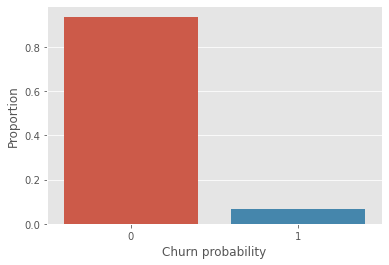

In [150]:
sns.barplot(data=data_hvc["churn_probability"].value_counts(normalize=True).reset_index(),
            x="index", y="churn_probability")
plt.xlabel("Churn probability")
plt.ylabel("Proportion")
plt.show()

<AxesSubplot:xlabel='churn_probability', ylabel='total_rech_amt'>

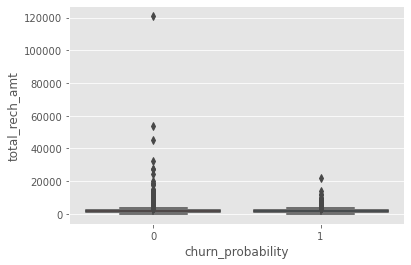

In [152]:
sns.boxplot(data=data_hvc, x="churn_probability", y="total_rech_amt")